In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostRegressor

In [2]:
df = pd.read_parquet("../data/structured/general/combined_data.parquet")
pred_in = pd.read_parquet("../data/raw/prediction_input.parquet")
pred_in

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,
1971-01-25 11:06:49,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,operation
1971-01-25 11:06:50,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,operation
1971-01-25 11:06:51,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,operation
1971-01-25 11:06:52,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,operation
1971-01-25 11:06:53,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,operation
...,...,...,...,...,...,...,...
1971-02-03 20:16:19,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,operation
1971-02-03 20:16:20,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,operation
1971-02-03 20:16:21,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,operation


## Structuring the prediction input data

In [3]:
index_series = pd.Series(pred_in.index, index=pred_in.index)
pred_in["days_since_start"] = index_series.diff().dt.days.cumsum()

pred_in["is_starting"] = pred_in["mode"].replace("operation", 0).replace("start", 1).astype(int)

pred_in["Netto Power"] = pred_in["Unit_4_Power"] - pred_in["Unit_4_Reactive Power"]

pred_in["Power / vane opening"] = pred_in["Unit_4_Power"] / pred_in["Turbine_Guide Vane Opening"]

pred_in["startnr"] = (pred_in["is_starting"]==1).cumsum()
pred_in["seconds_since_last_data"] = pd.Series(pred_in.index, index=pred_in.index).diff().dt.seconds
pred_in["seconds_since_last_start"] = pred_in.groupby("startnr")["seconds_since_last_data"].cumsum()
pred_in.loc[pred_in["is_starting"]==1, "seconds_since_last_start"] = 0

pred_in["Power / Drafttube pressure"] = pred_in["Unit_4_Power"] / pred_in["Turbine_Pressure Drafttube"]

## Training a model

In [4]:
df = df.dropna()
df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,...,Power / vane opening,seconds_since_last_data,seconds_since_last_start,Power / Drafttube pressure,Bolt_1_Tensile_adj,Bolt_2_Tensile_adj,Bolt_3_Tensile_adj,Bolt_4_Tensile_adj,Bolt_5_Tensile_adj,Bolt_6_Tensile_adj
timepoints,,,,,,,,,,,,,,,,,,,,,
1970-12-19 09:51:45,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,1598.477449,1480.989528,1684.261611,1601.366508,...,3.185623,1.0,1.0,1.506435,115.477449,43.989528,72.261611,3.366508,6.588478,38.823883
1970-12-19 09:51:46,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,1598.479316,1481.003188,1684.270504,1601.374254,...,3.184514,1.0,2.0,1.505561,115.479316,44.003188,72.270504,3.374254,6.583464,38.841318
1970-12-19 09:51:47,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,1598.490184,1481.028827,1684.270683,1601.383179,...,3.183404,1.0,3.0,1.504687,115.490184,44.028827,72.270683,3.383179,6.581384,38.843245
1970-12-19 09:51:48,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,1598.494073,1481.059017,1684.271062,1601.378391,...,3.182294,1.0,4.0,1.503294,115.494073,44.059017,72.271062,3.378391,6.591746,38.872300
1970-12-19 09:51:49,261.704362,3.170510,82.266336,174.422046,5312.533396,107.964254,1598.498916,1481.075521,1684.276622,1601.380601,...,3.181184,1.0,5.0,1.500409,115.498916,44.075521,72.276622,3.380601,6.607884,38.924469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01-25 11:06:44,308.716025,3.974309,94.425666,157.927905,5280.929965,108.057498,1637.386115,1504.557822,1701.651420,1606.276545,...,3.269408,1.0,19788.0,1.954791,154.386115,67.557822,89.651420,8.276545,11.704071,54.014705
1971-01-25 11:06:45,308.746393,4.103262,94.429003,157.974925,5280.633358,108.057492,1637.365865,1504.546091,1701.654301,1606.271877,...,3.269614,1.0,19789.0,1.954401,154.365865,67.546091,89.654301,8.271877,11.711250,54.017029
1971-01-25 11:06:46,308.776762,4.472929,94.432340,158.021945,5280.336751,108.057486,1637.384133,1504.538696,1701.656143,1606.250028,...,3.269820,1.0,19790.0,1.954012,154.384133,67.538696,89.656143,8.250028,11.699142,54.002008


In [5]:
X_cols = [
    'days_since_start',
    'Turbine_Pressure Drafttube',
    'seconds_since_last_start',
    'Netto Power',
    'Turbine_Rotational Speed'
]

y_cols = [c for c in df if c.endswith("Tensile")]

In [6]:
cX = df[X_cols]
cy = df[y_cols]

cX

,days_since_start,Turbine_Pressure Drafttube,seconds_since_last_start,Netto Power,Turbine_Rotational Speed
timepoints,,,,,
1970-12-19 09:51:45,0.0,173.989815,1.0,258.759689,107.964273
1970-12-19 09:51:46,0.0,174.024413,2.0,258.214106,107.964269
1970-12-19 09:51:47,0.0,174.059012,3.0,257.668524,107.964264
1970-12-19 09:51:48,0.0,174.153819,4.0,257.739592,107.964259
1970-12-19 09:51:49,0.0,174.422046,5.0,258.533851,107.964254
...,...,...,...,...,...
1971-01-25 11:06:44,5.0,157.927905,19788.0,304.741716,108.057498
1971-01-25 11:06:45,5.0,157.974925,19789.0,304.643131,108.057492
1971-01-25 11:06:46,5.0,158.021945,19790.0,304.303833,108.057486


In [9]:
params = {
    "loss_function": "MAPE",
    "iterations": 1000,
    "depth": 6,
    "random_strength": 0.2,
    "l2_leaf_reg": 0.2,
}

cys = [cy[c] for c in cy]

models = []
for i in range(len(cys)):
    model = CatBoostRegressor(**params)
    model.fit(cX, cys[i])
    models.append(model)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.0052906	total: 208ms	remaining: 3m 27s
1:	learn: 0.0051478	total: 405ms	remaining: 3m 22s
2:	learn: 0.0050093	total: 602ms	remaining: 3m 20s
3:	learn: 0.0048790	total: 817ms	remaining: 3m 23s
4:	learn: 0.0047503	total: 1.01s	remaining: 3m 21s
5:	learn: 0.0046285	total: 1.21s	remaining: 3m 20s
6:	learn: 0.0045105	total: 1.4s	remaining: 3m 18s
7:	learn: 0.0043948	total: 1.59s	remaining: 3m 17s
8:	learn: 0.0042843	total: 1.78s	remaining: 3m 16s
9:	learn: 0.0041768	total: 1.97s	remaining: 3m 15s
10:	learn: 0.0040735	total: 2.18s	remaining: 3m 16s
11:	learn: 0.0039735	total: 2.39s	remaining: 3m 16s
12:	learn: 0.0038780	total: 2.59s	remaining: 3m 16s
13:	learn: 0.0037867	total: 2.81s	remaining: 3m 17s
14:	learn: 0.0036987	total: 3.04s	remaining: 3m 19s
15:	learn: 0.0036137	total: 3.24s	remaining: 3m 19s
16:	learn: 0.0035289	total: 3.46s	remaining: 3m 20s
17:	learn: 0.0034499	total: 3.69s	remaining: 3m 21s
18:	learn: 0.0033709	total: 3.89s	remaining: 3m 20s
19:	learn: 0.0032948	to

159:	learn: 0.0007094	total: 32.3s	remaining: 2m 49s
160:	learn: 0.0007062	total: 32.6s	remaining: 2m 49s
161:	learn: 0.0007025	total: 32.8s	remaining: 2m 49s
162:	learn: 0.0006990	total: 33s	remaining: 2m 49s
163:	learn: 0.0006953	total: 33.2s	remaining: 2m 49s
164:	learn: 0.0006929	total: 33.4s	remaining: 2m 48s
165:	learn: 0.0006906	total: 33.6s	remaining: 2m 48s
166:	learn: 0.0006873	total: 33.8s	remaining: 2m 48s
167:	learn: 0.0006846	total: 34s	remaining: 2m 48s
168:	learn: 0.0006814	total: 34.2s	remaining: 2m 48s
169:	learn: 0.0006784	total: 34.4s	remaining: 2m 48s
170:	learn: 0.0006762	total: 34.6s	remaining: 2m 47s
171:	learn: 0.0006736	total: 34.8s	remaining: 2m 47s
172:	learn: 0.0006707	total: 35s	remaining: 2m 47s
173:	learn: 0.0006679	total: 35.2s	remaining: 2m 47s
174:	learn: 0.0006658	total: 35.4s	remaining: 2m 47s
175:	learn: 0.0006630	total: 35.6s	remaining: 2m 46s
176:	learn: 0.0006607	total: 35.8s	remaining: 2m 46s
177:	learn: 0.0006587	total: 36.1s	remaining: 2m 46s

315:	learn: 0.0005107	total: 1m 6s	remaining: 2m 23s
316:	learn: 0.0005103	total: 1m 6s	remaining: 2m 23s
317:	learn: 0.0005097	total: 1m 6s	remaining: 2m 23s
318:	learn: 0.0005092	total: 1m 7s	remaining: 2m 23s
319:	learn: 0.0005090	total: 1m 7s	remaining: 2m 22s
320:	learn: 0.0005086	total: 1m 7s	remaining: 2m 22s
321:	learn: 0.0005079	total: 1m 7s	remaining: 2m 22s
322:	learn: 0.0005075	total: 1m 7s	remaining: 2m 22s
323:	learn: 0.0005064	total: 1m 8s	remaining: 2m 21s
324:	learn: 0.0005059	total: 1m 8s	remaining: 2m 21s
325:	learn: 0.0005054	total: 1m 8s	remaining: 2m 21s
326:	learn: 0.0005049	total: 1m 8s	remaining: 2m 21s
327:	learn: 0.0005047	total: 1m 8s	remaining: 2m 20s
328:	learn: 0.0005043	total: 1m 8s	remaining: 2m 20s
329:	learn: 0.0005039	total: 1m 9s	remaining: 2m 20s
330:	learn: 0.0005034	total: 1m 9s	remaining: 2m 20s
331:	learn: 0.0005025	total: 1m 9s	remaining: 2m 20s
332:	learn: 0.0005020	total: 1m 9s	remaining: 2m 19s
333:	learn: 0.0005016	total: 1m 9s	remaining: 

469:	learn: 0.0004531	total: 1m 35s	remaining: 1m 47s
470:	learn: 0.0004529	total: 1m 35s	remaining: 1m 47s
471:	learn: 0.0004527	total: 1m 35s	remaining: 1m 47s
472:	learn: 0.0004525	total: 1m 35s	remaining: 1m 46s
473:	learn: 0.0004521	total: 1m 36s	remaining: 1m 46s
474:	learn: 0.0004520	total: 1m 36s	remaining: 1m 46s
475:	learn: 0.0004516	total: 1m 36s	remaining: 1m 46s
476:	learn: 0.0004512	total: 1m 36s	remaining: 1m 45s
477:	learn: 0.0004509	total: 1m 36s	remaining: 1m 45s
478:	learn: 0.0004506	total: 1m 36s	remaining: 1m 45s
479:	learn: 0.0004503	total: 1m 37s	remaining: 1m 45s
480:	learn: 0.0004501	total: 1m 37s	remaining: 1m 44s
481:	learn: 0.0004498	total: 1m 37s	remaining: 1m 44s
482:	learn: 0.0004496	total: 1m 37s	remaining: 1m 44s
483:	learn: 0.0004493	total: 1m 37s	remaining: 1m 44s
484:	learn: 0.0004490	total: 1m 38s	remaining: 1m 44s
485:	learn: 0.0004486	total: 1m 38s	remaining: 1m 43s
486:	learn: 0.0004483	total: 1m 38s	remaining: 1m 43s
487:	learn: 0.0004481	total:

622:	learn: 0.0004203	total: 2m 3s	remaining: 1m 14s
623:	learn: 0.0004201	total: 2m 3s	remaining: 1m 14s
624:	learn: 0.0004200	total: 2m 4s	remaining: 1m 14s
625:	learn: 0.0004198	total: 2m 4s	remaining: 1m 14s
626:	learn: 0.0004196	total: 2m 4s	remaining: 1m 13s
627:	learn: 0.0004195	total: 2m 4s	remaining: 1m 13s
628:	learn: 0.0004194	total: 2m 4s	remaining: 1m 13s
629:	learn: 0.0004192	total: 2m 4s	remaining: 1m 13s
630:	learn: 0.0004191	total: 2m 5s	remaining: 1m 13s
631:	learn: 0.0004190	total: 2m 5s	remaining: 1m 12s
632:	learn: 0.0004188	total: 2m 5s	remaining: 1m 12s
633:	learn: 0.0004188	total: 2m 5s	remaining: 1m 12s
634:	learn: 0.0004186	total: 2m 5s	remaining: 1m 12s
635:	learn: 0.0004185	total: 2m 6s	remaining: 1m 12s
636:	learn: 0.0004182	total: 2m 6s	remaining: 1m 11s
637:	learn: 0.0004182	total: 2m 6s	remaining: 1m 11s
638:	learn: 0.0004180	total: 2m 6s	remaining: 1m 11s
639:	learn: 0.0004179	total: 2m 6s	remaining: 1m 11s
640:	learn: 0.0004178	total: 2m 7s	remaining: 

778:	learn: 0.0003995	total: 2m 34s	remaining: 43.8s
779:	learn: 0.0003994	total: 2m 34s	remaining: 43.6s
780:	learn: 0.0003993	total: 2m 34s	remaining: 43.5s
781:	learn: 0.0003993	total: 2m 35s	remaining: 43.2s
782:	learn: 0.0003991	total: 2m 35s	remaining: 43.1s
783:	learn: 0.0003990	total: 2m 35s	remaining: 42.9s
784:	learn: 0.0003989	total: 2m 35s	remaining: 42.7s
785:	learn: 0.0003988	total: 2m 35s	remaining: 42.5s
786:	learn: 0.0003988	total: 2m 36s	remaining: 42.3s
787:	learn: 0.0003986	total: 2m 36s	remaining: 42.1s
788:	learn: 0.0003985	total: 2m 36s	remaining: 41.9s
789:	learn: 0.0003984	total: 2m 36s	remaining: 41.7s
790:	learn: 0.0003982	total: 2m 37s	remaining: 41.5s
791:	learn: 0.0003982	total: 2m 37s	remaining: 41.3s
792:	learn: 0.0003980	total: 2m 37s	remaining: 41.1s
793:	learn: 0.0003980	total: 2m 37s	remaining: 40.9s
794:	learn: 0.0003979	total: 2m 37s	remaining: 40.7s
795:	learn: 0.0003979	total: 2m 38s	remaining: 40.5s
796:	learn: 0.0003978	total: 2m 38s	remaining:

934:	learn: 0.0003853	total: 3m 8s	remaining: 13.1s
935:	learn: 0.0003852	total: 3m 8s	remaining: 12.9s
936:	learn: 0.0003851	total: 3m 9s	remaining: 12.7s
937:	learn: 0.0003850	total: 3m 9s	remaining: 12.5s
938:	learn: 0.0003849	total: 3m 9s	remaining: 12.3s
939:	learn: 0.0003849	total: 3m 9s	remaining: 12.1s
940:	learn: 0.0003848	total: 3m 10s	remaining: 11.9s
941:	learn: 0.0003847	total: 3m 10s	remaining: 11.7s
942:	learn: 0.0003847	total: 3m 10s	remaining: 11.5s
943:	learn: 0.0003846	total: 3m 10s	remaining: 11.3s
944:	learn: 0.0003846	total: 3m 10s	remaining: 11.1s
945:	learn: 0.0003845	total: 3m 11s	remaining: 10.9s
946:	learn: 0.0003845	total: 3m 11s	remaining: 10.7s
947:	learn: 0.0003844	total: 3m 11s	remaining: 10.5s
948:	learn: 0.0003843	total: 3m 11s	remaining: 10.3s
949:	learn: 0.0003843	total: 3m 11s	remaining: 10.1s
950:	learn: 0.0003842	total: 3m 12s	remaining: 9.9s
951:	learn: 0.0003842	total: 3m 12s	remaining: 9.7s
952:	learn: 0.0003842	total: 3m 12s	remaining: 9.49s
9

91:	learn: 0.0006142	total: 19.6s	remaining: 3m 13s
92:	learn: 0.0006086	total: 19.8s	remaining: 3m 13s
93:	learn: 0.0006000	total: 20s	remaining: 3m 12s
94:	learn: 0.0005915	total: 20.2s	remaining: 3m 12s
95:	learn: 0.0005839	total: 20.4s	remaining: 3m 12s
96:	learn: 0.0005759	total: 20.6s	remaining: 3m 11s
97:	learn: 0.0005681	total: 20.9s	remaining: 3m 11s
98:	learn: 0.0005606	total: 21.1s	remaining: 3m 11s
99:	learn: 0.0005534	total: 21.3s	remaining: 3m 11s
100:	learn: 0.0005467	total: 21.5s	remaining: 3m 11s
101:	learn: 0.0005399	total: 21.7s	remaining: 3m 10s
102:	learn: 0.0005336	total: 21.9s	remaining: 3m 10s
103:	learn: 0.0005270	total: 22.1s	remaining: 3m 10s
104:	learn: 0.0005210	total: 22.3s	remaining: 3m 10s
105:	learn: 0.0005151	total: 22.5s	remaining: 3m 9s
106:	learn: 0.0005096	total: 22.7s	remaining: 3m 9s
107:	learn: 0.0005042	total: 22.9s	remaining: 3m 9s
108:	learn: 0.0004992	total: 23.1s	remaining: 3m 9s
109:	learn: 0.0004942	total: 23.3s	remaining: 3m 8s
110:	lear

249:	learn: 0.0003101	total: 52.4s	remaining: 2m 37s
250:	learn: 0.0003099	total: 52.5s	remaining: 2m 36s
251:	learn: 0.0003097	total: 52.8s	remaining: 2m 36s
252:	learn: 0.0003094	total: 52.9s	remaining: 2m 36s
253:	learn: 0.0003091	total: 53.1s	remaining: 2m 36s
254:	learn: 0.0003086	total: 53.4s	remaining: 2m 35s
255:	learn: 0.0003082	total: 53.5s	remaining: 2m 35s
256:	learn: 0.0003080	total: 53.7s	remaining: 2m 35s
257:	learn: 0.0003078	total: 53.9s	remaining: 2m 35s
258:	learn: 0.0003076	total: 54.1s	remaining: 2m 34s
259:	learn: 0.0003074	total: 54.3s	remaining: 2m 34s
260:	learn: 0.0003072	total: 54.6s	remaining: 2m 34s
261:	learn: 0.0003068	total: 54.8s	remaining: 2m 34s
262:	learn: 0.0003066	total: 55s	remaining: 2m 34s
263:	learn: 0.0003063	total: 55.2s	remaining: 2m 33s
264:	learn: 0.0003058	total: 55.4s	remaining: 2m 33s
265:	learn: 0.0003055	total: 55.6s	remaining: 2m 33s
266:	learn: 0.0003051	total: 55.8s	remaining: 2m 33s
267:	learn: 0.0003050	total: 56s	remaining: 2m 3

405:	learn: 0.0002708	total: 1m 24s	remaining: 2m 3s
406:	learn: 0.0002705	total: 1m 24s	remaining: 2m 2s
407:	learn: 0.0002704	total: 1m 24s	remaining: 2m 2s
408:	learn: 0.0002702	total: 1m 24s	remaining: 2m 2s
409:	learn: 0.0002701	total: 1m 24s	remaining: 2m 2s
410:	learn: 0.0002699	total: 1m 25s	remaining: 2m 2s
411:	learn: 0.0002697	total: 1m 25s	remaining: 2m 1s
412:	learn: 0.0002696	total: 1m 25s	remaining: 2m 1s
413:	learn: 0.0002694	total: 1m 25s	remaining: 2m 1s
414:	learn: 0.0002691	total: 1m 26s	remaining: 2m 1s
415:	learn: 0.0002690	total: 1m 26s	remaining: 2m 1s
416:	learn: 0.0002689	total: 1m 26s	remaining: 2m
417:	learn: 0.0002687	total: 1m 26s	remaining: 2m
418:	learn: 0.0002685	total: 1m 26s	remaining: 2m
419:	learn: 0.0002684	total: 1m 27s	remaining: 2m
420:	learn: 0.0002683	total: 1m 27s	remaining: 2m
421:	learn: 0.0002682	total: 1m 27s	remaining: 1m 59s
422:	learn: 0.0002679	total: 1m 27s	remaining: 1m 59s
423:	learn: 0.0002677	total: 1m 27s	remaining: 1m 59s
424:	

559:	learn: 0.0002508	total: 1m 56s	remaining: 1m 31s
560:	learn: 0.0002507	total: 1m 56s	remaining: 1m 31s
561:	learn: 0.0002506	total: 1m 56s	remaining: 1m 30s
562:	learn: 0.0002505	total: 1m 56s	remaining: 1m 30s
563:	learn: 0.0002505	total: 1m 56s	remaining: 1m 30s
564:	learn: 0.0002504	total: 1m 57s	remaining: 1m 30s
565:	learn: 0.0002503	total: 1m 57s	remaining: 1m 29s
566:	learn: 0.0002503	total: 1m 57s	remaining: 1m 29s
567:	learn: 0.0002501	total: 1m 57s	remaining: 1m 29s
568:	learn: 0.0002501	total: 1m 57s	remaining: 1m 29s
569:	learn: 0.0002500	total: 1m 58s	remaining: 1m 29s
570:	learn: 0.0002499	total: 1m 58s	remaining: 1m 28s
571:	learn: 0.0002498	total: 1m 58s	remaining: 1m 28s
572:	learn: 0.0002497	total: 1m 58s	remaining: 1m 28s
573:	learn: 0.0002496	total: 1m 58s	remaining: 1m 28s
574:	learn: 0.0002496	total: 1m 59s	remaining: 1m 28s
575:	learn: 0.0002495	total: 1m 59s	remaining: 1m 27s
576:	learn: 0.0002494	total: 1m 59s	remaining: 1m 27s
577:	learn: 0.0002493	total:

714:	learn: 0.0002394	total: 2m 28s	remaining: 59.2s
715:	learn: 0.0002392	total: 2m 28s	remaining: 59s
716:	learn: 0.0002392	total: 2m 28s	remaining: 58.8s
717:	learn: 0.0002391	total: 2m 29s	remaining: 58.5s
718:	learn: 0.0002390	total: 2m 29s	remaining: 58.3s
719:	learn: 0.0002390	total: 2m 29s	remaining: 58.1s
720:	learn: 0.0002389	total: 2m 29s	remaining: 57.9s
721:	learn: 0.0002388	total: 2m 29s	remaining: 57.7s
722:	learn: 0.0002388	total: 2m 30s	remaining: 57.5s
723:	learn: 0.0002387	total: 2m 30s	remaining: 57.3s
724:	learn: 0.0002386	total: 2m 30s	remaining: 57.1s
725:	learn: 0.0002385	total: 2m 30s	remaining: 56.9s
726:	learn: 0.0002385	total: 2m 31s	remaining: 56.7s
727:	learn: 0.0002384	total: 2m 31s	remaining: 56.5s
728:	learn: 0.0002384	total: 2m 31s	remaining: 56.3s
729:	learn: 0.0002383	total: 2m 31s	remaining: 56.1s
730:	learn: 0.0002383	total: 2m 31s	remaining: 55.9s
731:	learn: 0.0002382	total: 2m 32s	remaining: 55.7s
732:	learn: 0.0002381	total: 2m 32s	remaining: 5

871:	learn: 0.0002290	total: 3m 2s	remaining: 26.7s
872:	learn: 0.0002289	total: 3m 2s	remaining: 26.5s
873:	learn: 0.0002289	total: 3m 2s	remaining: 26.3s
874:	learn: 0.0002288	total: 3m 2s	remaining: 26.1s
875:	learn: 0.0002288	total: 3m 2s	remaining: 25.9s
876:	learn: 0.0002287	total: 3m 3s	remaining: 25.7s
877:	learn: 0.0002287	total: 3m 3s	remaining: 25.5s
878:	learn: 0.0002286	total: 3m 3s	remaining: 25.3s
879:	learn: 0.0002286	total: 3m 3s	remaining: 25s
880:	learn: 0.0002285	total: 3m 3s	remaining: 24.8s
881:	learn: 0.0002285	total: 3m 4s	remaining: 24.6s
882:	learn: 0.0002285	total: 3m 4s	remaining: 24.4s
883:	learn: 0.0002283	total: 3m 4s	remaining: 24.2s
884:	learn: 0.0002283	total: 3m 4s	remaining: 24s
885:	learn: 0.0002282	total: 3m 4s	remaining: 23.8s
886:	learn: 0.0002282	total: 3m 5s	remaining: 23.6s
887:	learn: 0.0002281	total: 3m 5s	remaining: 23.4s
888:	learn: 0.0002280	total: 3m 5s	remaining: 23.2s
889:	learn: 0.0002279	total: 3m 5s	remaining: 23s
890:	learn: 0.0002

28:	learn: 0.0010941	total: 6.03s	remaining: 3m 22s
29:	learn: 0.0010669	total: 6.23s	remaining: 3m 21s
30:	learn: 0.0010404	total: 6.43s	remaining: 3m 20s
31:	learn: 0.0010146	total: 6.64s	remaining: 3m 21s
32:	learn: 0.0009901	total: 6.87s	remaining: 3m 21s
33:	learn: 0.0009665	total: 7.08s	remaining: 3m 21s
34:	learn: 0.0009432	total: 7.29s	remaining: 3m 21s
35:	learn: 0.0009204	total: 7.51s	remaining: 3m 21s
36:	learn: 0.0008984	total: 7.74s	remaining: 3m 21s
37:	learn: 0.0008775	total: 7.96s	remaining: 3m 21s
38:	learn: 0.0008558	total: 8.17s	remaining: 3m 21s
39:	learn: 0.0008350	total: 8.37s	remaining: 3m 20s
40:	learn: 0.0008147	total: 8.57s	remaining: 3m 20s
41:	learn: 0.0007949	total: 8.77s	remaining: 3m 20s
42:	learn: 0.0007760	total: 8.97s	remaining: 3m 19s
43:	learn: 0.0007577	total: 9.18s	remaining: 3m 19s
44:	learn: 0.0007401	total: 9.39s	remaining: 3m 19s
45:	learn: 0.0007230	total: 9.61s	remaining: 3m 19s
46:	learn: 0.0007063	total: 9.82s	remaining: 3m 19s
47:	learn: 0

186:	learn: 0.0001869	total: 40.2s	remaining: 2m 54s
187:	learn: 0.0001865	total: 40.4s	remaining: 2m 54s
188:	learn: 0.0001862	total: 40.6s	remaining: 2m 54s
189:	learn: 0.0001858	total: 40.8s	remaining: 2m 53s
190:	learn: 0.0001857	total: 41s	remaining: 2m 53s
191:	learn: 0.0001854	total: 41.2s	remaining: 2m 53s
192:	learn: 0.0001852	total: 41.4s	remaining: 2m 53s
193:	learn: 0.0001850	total: 41.6s	remaining: 2m 52s
194:	learn: 0.0001848	total: 41.8s	remaining: 2m 52s
195:	learn: 0.0001845	total: 42.1s	remaining: 2m 52s
196:	learn: 0.0001844	total: 42.3s	remaining: 2m 52s
197:	learn: 0.0001841	total: 42.5s	remaining: 2m 52s
198:	learn: 0.0001838	total: 42.7s	remaining: 2m 51s
199:	learn: 0.0001836	total: 42.9s	remaining: 2m 51s
200:	learn: 0.0001835	total: 43.1s	remaining: 2m 51s
201:	learn: 0.0001833	total: 43.3s	remaining: 2m 51s
202:	learn: 0.0001830	total: 43.5s	remaining: 2m 50s
203:	learn: 0.0001829	total: 43.7s	remaining: 2m 50s
204:	learn: 0.0001826	total: 43.9s	remaining: 2m

342:	learn: 0.0001535	total: 1m 12s	remaining: 2m 18s
343:	learn: 0.0001534	total: 1m 12s	remaining: 2m 18s
344:	learn: 0.0001532	total: 1m 12s	remaining: 2m 18s
345:	learn: 0.0001531	total: 1m 12s	remaining: 2m 17s
346:	learn: 0.0001530	total: 1m 13s	remaining: 2m 17s
347:	learn: 0.0001529	total: 1m 13s	remaining: 2m 17s
348:	learn: 0.0001527	total: 1m 13s	remaining: 2m 17s
349:	learn: 0.0001526	total: 1m 13s	remaining: 2m 17s
350:	learn: 0.0001525	total: 1m 14s	remaining: 2m 16s
351:	learn: 0.0001524	total: 1m 14s	remaining: 2m 16s
352:	learn: 0.0001523	total: 1m 14s	remaining: 2m 16s
353:	learn: 0.0001522	total: 1m 14s	remaining: 2m 16s
354:	learn: 0.0001520	total: 1m 14s	remaining: 2m 16s
355:	learn: 0.0001518	total: 1m 15s	remaining: 2m 15s
356:	learn: 0.0001518	total: 1m 15s	remaining: 2m 15s
357:	learn: 0.0001517	total: 1m 15s	remaining: 2m 15s
358:	learn: 0.0001515	total: 1m 15s	remaining: 2m 15s
359:	learn: 0.0001514	total: 1m 15s	remaining: 2m 14s
360:	learn: 0.0001512	total:

495:	learn: 0.0001376	total: 1m 43s	remaining: 1m 45s
496:	learn: 0.0001375	total: 1m 43s	remaining: 1m 44s
497:	learn: 0.0001374	total: 1m 43s	remaining: 1m 44s
498:	learn: 0.0001374	total: 1m 44s	remaining: 1m 44s
499:	learn: 0.0001373	total: 1m 44s	remaining: 1m 44s
500:	learn: 0.0001372	total: 1m 44s	remaining: 1m 44s
501:	learn: 0.0001371	total: 1m 44s	remaining: 1m 43s
502:	learn: 0.0001370	total: 1m 45s	remaining: 1m 43s
503:	learn: 0.0001369	total: 1m 45s	remaining: 1m 43s
504:	learn: 0.0001368	total: 1m 45s	remaining: 1m 43s
505:	learn: 0.0001368	total: 1m 45s	remaining: 1m 43s
506:	learn: 0.0001367	total: 1m 45s	remaining: 1m 42s
507:	learn: 0.0001366	total: 1m 46s	remaining: 1m 42s
508:	learn: 0.0001365	total: 1m 46s	remaining: 1m 42s
509:	learn: 0.0001364	total: 1m 46s	remaining: 1m 42s
510:	learn: 0.0001364	total: 1m 46s	remaining: 1m 42s
511:	learn: 0.0001363	total: 1m 46s	remaining: 1m 41s
512:	learn: 0.0001362	total: 1m 47s	remaining: 1m 41s
513:	learn: 0.0001361	total:

648:	learn: 0.0001283	total: 2m 15s	remaining: 1m 13s
649:	learn: 0.0001283	total: 2m 16s	remaining: 1m 13s
650:	learn: 0.0001283	total: 2m 16s	remaining: 1m 13s
651:	learn: 0.0001282	total: 2m 16s	remaining: 1m 12s
652:	learn: 0.0001282	total: 2m 16s	remaining: 1m 12s
653:	learn: 0.0001281	total: 2m 16s	remaining: 1m 12s
654:	learn: 0.0001280	total: 2m 17s	remaining: 1m 12s
655:	learn: 0.0001280	total: 2m 17s	remaining: 1m 11s
656:	learn: 0.0001280	total: 2m 17s	remaining: 1m 11s
657:	learn: 0.0001279	total: 2m 17s	remaining: 1m 11s
658:	learn: 0.0001279	total: 2m 17s	remaining: 1m 11s
659:	learn: 0.0001279	total: 2m 17s	remaining: 1m 11s
660:	learn: 0.0001278	total: 2m 18s	remaining: 1m 10s
661:	learn: 0.0001278	total: 2m 18s	remaining: 1m 10s
662:	learn: 0.0001277	total: 2m 18s	remaining: 1m 10s
663:	learn: 0.0001277	total: 2m 18s	remaining: 1m 10s
664:	learn: 0.0001276	total: 2m 18s	remaining: 1m 9s
665:	learn: 0.0001276	total: 2m 19s	remaining: 1m 9s
666:	learn: 0.0001275	total: 2

803:	learn: 0.0001215	total: 2m 45s	remaining: 40.3s
804:	learn: 0.0001215	total: 2m 45s	remaining: 40.1s
805:	learn: 0.0001214	total: 2m 45s	remaining: 39.9s
806:	learn: 0.0001214	total: 2m 45s	remaining: 39.7s
807:	learn: 0.0001214	total: 2m 46s	remaining: 39.5s
808:	learn: 0.0001213	total: 2m 46s	remaining: 39.2s
809:	learn: 0.0001213	total: 2m 46s	remaining: 39s
810:	learn: 0.0001212	total: 2m 46s	remaining: 38.8s
811:	learn: 0.0001212	total: 2m 46s	remaining: 38.6s
812:	learn: 0.0001212	total: 2m 47s	remaining: 38.4s
813:	learn: 0.0001211	total: 2m 47s	remaining: 38.2s
814:	learn: 0.0001210	total: 2m 47s	remaining: 38s
815:	learn: 0.0001210	total: 2m 47s	remaining: 37.8s
816:	learn: 0.0001210	total: 2m 47s	remaining: 37.6s
817:	learn: 0.0001209	total: 2m 48s	remaining: 37.4s
818:	learn: 0.0001209	total: 2m 48s	remaining: 37.2s
819:	learn: 0.0001208	total: 2m 48s	remaining: 37s
820:	learn: 0.0001208	total: 2m 48s	remaining: 36.8s
821:	learn: 0.0001207	total: 2m 48s	remaining: 36.6s

961:	learn: 0.0001141	total: 3m 17s	remaining: 7.79s
962:	learn: 0.0001141	total: 3m 17s	remaining: 7.58s
963:	learn: 0.0001141	total: 3m 17s	remaining: 7.38s
964:	learn: 0.0001140	total: 3m 17s	remaining: 7.17s
965:	learn: 0.0001140	total: 3m 18s	remaining: 6.97s
966:	learn: 0.0001140	total: 3m 18s	remaining: 6.76s
967:	learn: 0.0001139	total: 3m 18s	remaining: 6.56s
968:	learn: 0.0001139	total: 3m 18s	remaining: 6.35s
969:	learn: 0.0001139	total: 3m 18s	remaining: 6.14s
970:	learn: 0.0001138	total: 3m 18s	remaining: 5.94s
971:	learn: 0.0001138	total: 3m 19s	remaining: 5.73s
972:	learn: 0.0001137	total: 3m 19s	remaining: 5.53s
973:	learn: 0.0001137	total: 3m 19s	remaining: 5.33s
974:	learn: 0.0001137	total: 3m 19s	remaining: 5.12s
975:	learn: 0.0001136	total: 3m 19s	remaining: 4.92s
976:	learn: 0.0001136	total: 3m 20s	remaining: 4.71s
977:	learn: 0.0001135	total: 3m 20s	remaining: 4.5s
978:	learn: 0.0001135	total: 3m 20s	remaining: 4.3s
979:	learn: 0.0001134	total: 3m 20s	remaining: 4

120:	learn: 0.0002119	total: 23.8s	remaining: 2m 52s
121:	learn: 0.0002113	total: 24s	remaining: 2m 52s
122:	learn: 0.0002105	total: 24.2s	remaining: 2m 52s
123:	learn: 0.0002100	total: 24.4s	remaining: 2m 52s
124:	learn: 0.0002094	total: 24.6s	remaining: 2m 51s
125:	learn: 0.0002088	total: 24.7s	remaining: 2m 51s
126:	learn: 0.0002082	total: 24.9s	remaining: 2m 51s
127:	learn: 0.0002076	total: 25.1s	remaining: 2m 51s
128:	learn: 0.0002071	total: 25.3s	remaining: 2m 51s
129:	learn: 0.0002066	total: 25.5s	remaining: 2m 50s
130:	learn: 0.0002061	total: 25.7s	remaining: 2m 50s
131:	learn: 0.0002057	total: 25.9s	remaining: 2m 50s
132:	learn: 0.0002052	total: 26.1s	remaining: 2m 50s
133:	learn: 0.0002047	total: 26.3s	remaining: 2m 50s
134:	learn: 0.0002042	total: 26.5s	remaining: 2m 49s
135:	learn: 0.0002038	total: 26.7s	remaining: 2m 49s
136:	learn: 0.0002033	total: 26.9s	remaining: 2m 49s
137:	learn: 0.0002029	total: 27.1s	remaining: 2m 49s
138:	learn: 0.0002024	total: 27.3s	remaining: 2m

277:	learn: 0.0001610	total: 55.1s	remaining: 2m 23s
278:	learn: 0.0001608	total: 55.3s	remaining: 2m 22s
279:	learn: 0.0001606	total: 55.5s	remaining: 2m 22s
280:	learn: 0.0001604	total: 55.7s	remaining: 2m 22s
281:	learn: 0.0001602	total: 55.9s	remaining: 2m 22s
282:	learn: 0.0001600	total: 56.1s	remaining: 2m 22s
283:	learn: 0.0001598	total: 56.3s	remaining: 2m 21s
284:	learn: 0.0001594	total: 56.5s	remaining: 2m 21s
285:	learn: 0.0001592	total: 56.7s	remaining: 2m 21s
286:	learn: 0.0001591	total: 56.9s	remaining: 2m 21s
287:	learn: 0.0001588	total: 57.1s	remaining: 2m 21s
288:	learn: 0.0001585	total: 57.3s	remaining: 2m 21s
289:	learn: 0.0001584	total: 57.5s	remaining: 2m 20s
290:	learn: 0.0001583	total: 57.7s	remaining: 2m 20s
291:	learn: 0.0001581	total: 57.9s	remaining: 2m 20s
292:	learn: 0.0001580	total: 58.1s	remaining: 2m 20s
293:	learn: 0.0001579	total: 58.3s	remaining: 2m 20s
294:	learn: 0.0001577	total: 58.5s	remaining: 2m 19s
295:	learn: 0.0001575	total: 58.7s	remaining: 

432:	learn: 0.0001416	total: 1m 28s	remaining: 1m 55s
433:	learn: 0.0001415	total: 1m 28s	remaining: 1m 55s
434:	learn: 0.0001413	total: 1m 28s	remaining: 1m 54s
435:	learn: 0.0001413	total: 1m 28s	remaining: 1m 54s
436:	learn: 0.0001413	total: 1m 28s	remaining: 1m 54s
437:	learn: 0.0001411	total: 1m 29s	remaining: 1m 54s
438:	learn: 0.0001410	total: 1m 29s	remaining: 1m 54s
439:	learn: 0.0001409	total: 1m 29s	remaining: 1m 53s
440:	learn: 0.0001408	total: 1m 29s	remaining: 1m 53s
441:	learn: 0.0001406	total: 1m 29s	remaining: 1m 53s
442:	learn: 0.0001405	total: 1m 30s	remaining: 1m 53s
443:	learn: 0.0001404	total: 1m 30s	remaining: 1m 53s
444:	learn: 0.0001404	total: 1m 30s	remaining: 1m 53s
445:	learn: 0.0001403	total: 1m 30s	remaining: 1m 52s
446:	learn: 0.0001402	total: 1m 31s	remaining: 1m 52s
447:	learn: 0.0001402	total: 1m 31s	remaining: 1m 52s
448:	learn: 0.0001401	total: 1m 31s	remaining: 1m 52s
449:	learn: 0.0001401	total: 1m 31s	remaining: 1m 52s
450:	learn: 0.0001400	total:

585:	learn: 0.0001309	total: 2m 4s	remaining: 1m 27s
586:	learn: 0.0001309	total: 2m 4s	remaining: 1m 27s
587:	learn: 0.0001307	total: 2m 4s	remaining: 1m 27s
588:	learn: 0.0001307	total: 2m 4s	remaining: 1m 27s
589:	learn: 0.0001306	total: 2m 5s	remaining: 1m 26s
590:	learn: 0.0001305	total: 2m 5s	remaining: 1m 26s
591:	learn: 0.0001305	total: 2m 5s	remaining: 1m 26s
592:	learn: 0.0001304	total: 2m 5s	remaining: 1m 26s
593:	learn: 0.0001304	total: 2m 5s	remaining: 1m 26s
594:	learn: 0.0001303	total: 2m 6s	remaining: 1m 25s
595:	learn: 0.0001303	total: 2m 6s	remaining: 1m 25s
596:	learn: 0.0001302	total: 2m 6s	remaining: 1m 25s
597:	learn: 0.0001302	total: 2m 6s	remaining: 1m 25s
598:	learn: 0.0001302	total: 2m 7s	remaining: 1m 25s
599:	learn: 0.0001301	total: 2m 7s	remaining: 1m 24s
600:	learn: 0.0001300	total: 2m 7s	remaining: 1m 24s
601:	learn: 0.0001299	total: 2m 7s	remaining: 1m 24s
602:	learn: 0.0001299	total: 2m 7s	remaining: 1m 24s
603:	learn: 0.0001298	total: 2m 8s	remaining: 

739:	learn: 0.0001226	total: 2m 36s	remaining: 55s
740:	learn: 0.0001226	total: 2m 36s	remaining: 54.8s
741:	learn: 0.0001225	total: 2m 37s	remaining: 54.6s
742:	learn: 0.0001223	total: 2m 37s	remaining: 54.4s
743:	learn: 0.0001223	total: 2m 37s	remaining: 54.2s
744:	learn: 0.0001222	total: 2m 37s	remaining: 54s
745:	learn: 0.0001220	total: 2m 37s	remaining: 53.8s
746:	learn: 0.0001220	total: 2m 38s	remaining: 53.5s
747:	learn: 0.0001219	total: 2m 38s	remaining: 53.3s
748:	learn: 0.0001219	total: 2m 38s	remaining: 53.1s
749:	learn: 0.0001219	total: 2m 38s	remaining: 52.9s
750:	learn: 0.0001219	total: 2m 38s	remaining: 52.7s
751:	learn: 0.0001218	total: 2m 39s	remaining: 52.5s
752:	learn: 0.0001218	total: 2m 39s	remaining: 52.3s
753:	learn: 0.0001217	total: 2m 39s	remaining: 52s
754:	learn: 0.0001217	total: 2m 39s	remaining: 51.8s
755:	learn: 0.0001217	total: 2m 39s	remaining: 51.6s
756:	learn: 0.0001216	total: 2m 40s	remaining: 51.4s
757:	learn: 0.0001216	total: 2m 40s	remaining: 51.2s

896:	learn: 0.0001143	total: 3m 8s	remaining: 21.7s
897:	learn: 0.0001143	total: 3m 8s	remaining: 21.4s
898:	learn: 0.0001142	total: 3m 8s	remaining: 21.2s
899:	learn: 0.0001142	total: 3m 9s	remaining: 21s
900:	learn: 0.0001142	total: 3m 9s	remaining: 20.8s
901:	learn: 0.0001141	total: 3m 9s	remaining: 20.6s
902:	learn: 0.0001139	total: 3m 9s	remaining: 20.4s
903:	learn: 0.0001139	total: 3m 9s	remaining: 20.2s
904:	learn: 0.0001138	total: 3m 10s	remaining: 20s
905:	learn: 0.0001138	total: 3m 10s	remaining: 19.7s
906:	learn: 0.0001137	total: 3m 10s	remaining: 19.5s
907:	learn: 0.0001135	total: 3m 10s	remaining: 19.3s
908:	learn: 0.0001135	total: 3m 10s	remaining: 19.1s
909:	learn: 0.0001133	total: 3m 11s	remaining: 18.9s
910:	learn: 0.0001131	total: 3m 11s	remaining: 18.7s
911:	learn: 0.0001130	total: 3m 11s	remaining: 18.5s
912:	learn: 0.0001129	total: 3m 11s	remaining: 18.3s
913:	learn: 0.0001129	total: 3m 11s	remaining: 18.1s
914:	learn: 0.0001128	total: 3m 12s	remaining: 17.8s
915:	

54:	learn: 0.0002764	total: 8.04s	remaining: 2m 18s
55:	learn: 0.0002735	total: 8.19s	remaining: 2m 18s
56:	learn: 0.0002708	total: 8.34s	remaining: 2m 17s
57:	learn: 0.0002678	total: 8.48s	remaining: 2m 17s
58:	learn: 0.0002650	total: 8.63s	remaining: 2m 17s
59:	learn: 0.0002622	total: 8.78s	remaining: 2m 17s
60:	learn: 0.0002599	total: 8.93s	remaining: 2m 17s
61:	learn: 0.0002572	total: 9.08s	remaining: 2m 17s
62:	learn: 0.0002547	total: 9.23s	remaining: 2m 17s
63:	learn: 0.0002521	total: 9.39s	remaining: 2m 17s
64:	learn: 0.0002498	total: 9.53s	remaining: 2m 17s
65:	learn: 0.0002475	total: 9.68s	remaining: 2m 17s
66:	learn: 0.0002453	total: 9.83s	remaining: 2m 16s
67:	learn: 0.0002435	total: 9.98s	remaining: 2m 16s
68:	learn: 0.0002415	total: 10.1s	remaining: 2m 16s
69:	learn: 0.0002399	total: 10.3s	remaining: 2m 16s
70:	learn: 0.0002379	total: 10.4s	remaining: 2m 16s
71:	learn: 0.0002360	total: 10.6s	remaining: 2m 16s
72:	learn: 0.0002342	total: 10.7s	remaining: 2m 15s
73:	learn: 0

212:	learn: 0.0001630	total: 31.4s	remaining: 1m 55s
213:	learn: 0.0001628	total: 31.5s	remaining: 1m 55s
214:	learn: 0.0001626	total: 31.7s	remaining: 1m 55s
215:	learn: 0.0001624	total: 31.8s	remaining: 1m 55s
216:	learn: 0.0001622	total: 32s	remaining: 1m 55s
217:	learn: 0.0001620	total: 32.1s	remaining: 1m 55s
218:	learn: 0.0001617	total: 32.3s	remaining: 1m 55s
219:	learn: 0.0001614	total: 32.4s	remaining: 1m 54s
220:	learn: 0.0001611	total: 32.6s	remaining: 1m 54s
221:	learn: 0.0001609	total: 32.7s	remaining: 1m 54s
222:	learn: 0.0001607	total: 32.9s	remaining: 1m 54s
223:	learn: 0.0001605	total: 33s	remaining: 1m 54s
224:	learn: 0.0001603	total: 33.2s	remaining: 1m 54s
225:	learn: 0.0001602	total: 33.3s	remaining: 1m 54s
226:	learn: 0.0001600	total: 33.5s	remaining: 1m 53s
227:	learn: 0.0001598	total: 33.6s	remaining: 1m 53s
228:	learn: 0.0001595	total: 33.8s	remaining: 1m 53s
229:	learn: 0.0001593	total: 33.9s	remaining: 1m 53s
230:	learn: 0.0001590	total: 34.1s	remaining: 1m 5

369:	learn: 0.0001390	total: 55.7s	remaining: 1m 34s
370:	learn: 0.0001389	total: 55.8s	remaining: 1m 34s
371:	learn: 0.0001388	total: 56s	remaining: 1m 34s
372:	learn: 0.0001387	total: 56.1s	remaining: 1m 34s
373:	learn: 0.0001386	total: 56.3s	remaining: 1m 34s
374:	learn: 0.0001384	total: 56.4s	remaining: 1m 34s
375:	learn: 0.0001382	total: 56.6s	remaining: 1m 33s
376:	learn: 0.0001382	total: 56.7s	remaining: 1m 33s
377:	learn: 0.0001381	total: 56.9s	remaining: 1m 33s
378:	learn: 0.0001380	total: 57s	remaining: 1m 33s
379:	learn: 0.0001378	total: 57.2s	remaining: 1m 33s
380:	learn: 0.0001377	total: 57.4s	remaining: 1m 33s
381:	learn: 0.0001376	total: 57.5s	remaining: 1m 33s
382:	learn: 0.0001375	total: 57.7s	remaining: 1m 32s
383:	learn: 0.0001374	total: 57.8s	remaining: 1m 32s
384:	learn: 0.0001372	total: 58s	remaining: 1m 32s
385:	learn: 0.0001371	total: 58.1s	remaining: 1m 32s
386:	learn: 0.0001371	total: 58.3s	remaining: 1m 32s
387:	learn: 0.0001371	total: 58.4s	remaining: 1m 32s

523:	learn: 0.0001282	total: 1m 19s	remaining: 1m 11s
524:	learn: 0.0001282	total: 1m 19s	remaining: 1m 11s
525:	learn: 0.0001281	total: 1m 19s	remaining: 1m 11s
526:	learn: 0.0001281	total: 1m 19s	remaining: 1m 11s
527:	learn: 0.0001280	total: 1m 19s	remaining: 1m 11s
528:	learn: 0.0001280	total: 1m 19s	remaining: 1m 11s
529:	learn: 0.0001280	total: 1m 20s	remaining: 1m 10s
530:	learn: 0.0001279	total: 1m 20s	remaining: 1m 10s
531:	learn: 0.0001279	total: 1m 20s	remaining: 1m 10s
532:	learn: 0.0001278	total: 1m 20s	remaining: 1m 10s
533:	learn: 0.0001278	total: 1m 20s	remaining: 1m 10s
534:	learn: 0.0001277	total: 1m 20s	remaining: 1m 10s
535:	learn: 0.0001277	total: 1m 20s	remaining: 1m 10s
536:	learn: 0.0001277	total: 1m 21s	remaining: 1m 9s
537:	learn: 0.0001276	total: 1m 21s	remaining: 1m 9s
538:	learn: 0.0001276	total: 1m 21s	remaining: 1m 9s
539:	learn: 0.0001275	total: 1m 21s	remaining: 1m 9s
540:	learn: 0.0001275	total: 1m 21s	remaining: 1m 9s
541:	learn: 0.0001274	total: 1m 2

680:	learn: 0.0001219	total: 1m 45s	remaining: 49.2s
681:	learn: 0.0001219	total: 1m 45s	remaining: 49s
682:	learn: 0.0001218	total: 1m 45s	remaining: 48.9s
683:	learn: 0.0001218	total: 1m 45s	remaining: 48.7s
684:	learn: 0.0001218	total: 1m 45s	remaining: 48.6s
685:	learn: 0.0001217	total: 1m 45s	remaining: 48.4s
686:	learn: 0.0001216	total: 1m 45s	remaining: 48.3s
687:	learn: 0.0001216	total: 1m 46s	remaining: 48.1s
688:	learn: 0.0001216	total: 1m 46s	remaining: 48s
689:	learn: 0.0001215	total: 1m 46s	remaining: 47.8s
690:	learn: 0.0001215	total: 1m 46s	remaining: 47.7s
691:	learn: 0.0001215	total: 1m 46s	remaining: 47.5s
692:	learn: 0.0001214	total: 1m 46s	remaining: 47.4s
693:	learn: 0.0001214	total: 1m 47s	remaining: 47.2s
694:	learn: 0.0001214	total: 1m 47s	remaining: 47.1s
695:	learn: 0.0001214	total: 1m 47s	remaining: 46.9s
696:	learn: 0.0001213	total: 1m 47s	remaining: 46.8s
697:	learn: 0.0001213	total: 1m 47s	remaining: 46.6s
698:	learn: 0.0001213	total: 1m 47s	remaining: 46.

838:	learn: 0.0001176	total: 2m 10s	remaining: 25s
839:	learn: 0.0001176	total: 2m 10s	remaining: 24.8s
840:	learn: 0.0001175	total: 2m 10s	remaining: 24.7s
841:	learn: 0.0001175	total: 2m 10s	remaining: 24.5s
842:	learn: 0.0001175	total: 2m 10s	remaining: 24.4s
843:	learn: 0.0001175	total: 2m 11s	remaining: 24.2s
844:	learn: 0.0001174	total: 2m 11s	remaining: 24.1s
845:	learn: 0.0001174	total: 2m 11s	remaining: 23.9s
846:	learn: 0.0001174	total: 2m 11s	remaining: 23.8s
847:	learn: 0.0001174	total: 2m 11s	remaining: 23.6s
848:	learn: 0.0001173	total: 2m 11s	remaining: 23.5s
849:	learn: 0.0001173	total: 2m 12s	remaining: 23.3s
850:	learn: 0.0001173	total: 2m 12s	remaining: 23.2s
851:	learn: 0.0001173	total: 2m 12s	remaining: 23s
852:	learn: 0.0001173	total: 2m 12s	remaining: 22.9s
853:	learn: 0.0001173	total: 2m 12s	remaining: 22.7s
854:	learn: 0.0001173	total: 2m 12s	remaining: 22.6s
855:	learn: 0.0001172	total: 2m 13s	remaining: 22.4s
856:	learn: 0.0001172	total: 2m 13s	remaining: 22.

994:	learn: 0.0001143	total: 2m 36s	remaining: 786ms
995:	learn: 0.0001143	total: 2m 36s	remaining: 629ms
996:	learn: 0.0001142	total: 2m 36s	remaining: 471ms
997:	learn: 0.0001142	total: 2m 36s	remaining: 314ms
998:	learn: 0.0001142	total: 2m 36s	remaining: 157ms
999:	learn: 0.0001142	total: 2m 37s	remaining: 0us
0:	learn: 0.0019308	total: 173ms	remaining: 2m 52s
1:	learn: 0.0018762	total: 344ms	remaining: 2m 51s
2:	learn: 0.0018233	total: 510ms	remaining: 2m 49s
3:	learn: 0.0017719	total: 671ms	remaining: 2m 47s
4:	learn: 0.0017220	total: 831ms	remaining: 2m 45s
5:	learn: 0.0016739	total: 993ms	remaining: 2m 44s
6:	learn: 0.0016282	total: 1.15s	remaining: 2m 43s
7:	learn: 0.0015831	total: 1.31s	remaining: 2m 43s
8:	learn: 0.0015405	total: 1.48s	remaining: 2m 42s
9:	learn: 0.0014986	total: 1.64s	remaining: 2m 42s
10:	learn: 0.0014580	total: 1.8s	remaining: 2m 42s
11:	learn: 0.0014187	total: 1.97s	remaining: 2m 42s
12:	learn: 0.0013807	total: 2.14s	remaining: 2m 42s
13:	learn: 0.001343

152:	learn: 0.0002088	total: 25.3s	remaining: 2m 20s
153:	learn: 0.0002080	total: 25.5s	remaining: 2m 19s
154:	learn: 0.0002073	total: 25.6s	remaining: 2m 19s
155:	learn: 0.0002066	total: 25.8s	remaining: 2m 19s
156:	learn: 0.0002060	total: 25.9s	remaining: 2m 19s
157:	learn: 0.0002053	total: 26.1s	remaining: 2m 19s
158:	learn: 0.0002047	total: 26.3s	remaining: 2m 18s
159:	learn: 0.0002041	total: 26.4s	remaining: 2m 18s
160:	learn: 0.0002034	total: 26.5s	remaining: 2m 18s
161:	learn: 0.0002029	total: 26.7s	remaining: 2m 18s
162:	learn: 0.0002022	total: 26.9s	remaining: 2m 17s
163:	learn: 0.0002017	total: 27s	remaining: 2m 17s
164:	learn: 0.0002010	total: 27.1s	remaining: 2m 17s
165:	learn: 0.0002005	total: 27.3s	remaining: 2m 17s
166:	learn: 0.0002000	total: 27.4s	remaining: 2m 16s
167:	learn: 0.0001995	total: 27.6s	remaining: 2m 16s
168:	learn: 0.0001990	total: 27.8s	remaining: 2m 16s
169:	learn: 0.0001986	total: 27.9s	remaining: 2m 16s
170:	learn: 0.0001981	total: 28.1s	remaining: 2m

310:	learn: 0.0001627	total: 49.4s	remaining: 1m 49s
311:	learn: 0.0001625	total: 49.5s	remaining: 1m 49s
312:	learn: 0.0001624	total: 49.7s	remaining: 1m 49s
313:	learn: 0.0001623	total: 49.8s	remaining: 1m 48s
314:	learn: 0.0001621	total: 50s	remaining: 1m 48s
315:	learn: 0.0001619	total: 50.2s	remaining: 1m 48s
316:	learn: 0.0001618	total: 50.3s	remaining: 1m 48s
317:	learn: 0.0001617	total: 50.5s	remaining: 1m 48s
318:	learn: 0.0001615	total: 50.6s	remaining: 1m 48s
319:	learn: 0.0001614	total: 50.8s	remaining: 1m 47s
320:	learn: 0.0001613	total: 51s	remaining: 1m 47s
321:	learn: 0.0001611	total: 51.1s	remaining: 1m 47s
322:	learn: 0.0001610	total: 51.3s	remaining: 1m 47s
323:	learn: 0.0001607	total: 51.4s	remaining: 1m 47s
324:	learn: 0.0001606	total: 51.6s	remaining: 1m 47s
325:	learn: 0.0001606	total: 51.7s	remaining: 1m 46s
326:	learn: 0.0001605	total: 51.9s	remaining: 1m 46s
327:	learn: 0.0001603	total: 52s	remaining: 1m 46s
328:	learn: 0.0001603	total: 52.2s	remaining: 1m 46s

466:	learn: 0.0001469	total: 1m 12s	remaining: 1m 23s
467:	learn: 0.0001468	total: 1m 13s	remaining: 1m 23s
468:	learn: 0.0001468	total: 1m 13s	remaining: 1m 22s
469:	learn: 0.0001467	total: 1m 13s	remaining: 1m 22s
470:	learn: 0.0001467	total: 1m 13s	remaining: 1m 22s
471:	learn: 0.0001466	total: 1m 13s	remaining: 1m 22s
472:	learn: 0.0001465	total: 1m 13s	remaining: 1m 22s
473:	learn: 0.0001464	total: 1m 14s	remaining: 1m 22s
474:	learn: 0.0001464	total: 1m 14s	remaining: 1m 21s
475:	learn: 0.0001463	total: 1m 14s	remaining: 1m 21s
476:	learn: 0.0001463	total: 1m 14s	remaining: 1m 21s
477:	learn: 0.0001462	total: 1m 14s	remaining: 1m 21s
478:	learn: 0.0001462	total: 1m 14s	remaining: 1m 21s
479:	learn: 0.0001460	total: 1m 15s	remaining: 1m 21s
480:	learn: 0.0001460	total: 1m 15s	remaining: 1m 21s
481:	learn: 0.0001459	total: 1m 15s	remaining: 1m 20s
482:	learn: 0.0001459	total: 1m 15s	remaining: 1m 20s
483:	learn: 0.0001458	total: 1m 15s	remaining: 1m 20s
484:	learn: 0.0001457	total:

620:	learn: 0.0001383	total: 1m 37s	remaining: 59.2s
621:	learn: 0.0001382	total: 1m 37s	remaining: 59.1s
622:	learn: 0.0001382	total: 1m 37s	remaining: 58.9s
623:	learn: 0.0001381	total: 1m 37s	remaining: 58.8s
624:	learn: 0.0001381	total: 1m 37s	remaining: 58.6s
625:	learn: 0.0001380	total: 1m 37s	remaining: 58.4s
626:	learn: 0.0001380	total: 1m 37s	remaining: 58.3s
627:	learn: 0.0001379	total: 1m 38s	remaining: 58.1s
628:	learn: 0.0001379	total: 1m 38s	remaining: 58s
629:	learn: 0.0001379	total: 1m 38s	remaining: 57.8s
630:	learn: 0.0001378	total: 1m 38s	remaining: 57.7s
631:	learn: 0.0001378	total: 1m 38s	remaining: 57.5s
632:	learn: 0.0001378	total: 1m 38s	remaining: 57.3s
633:	learn: 0.0001377	total: 1m 39s	remaining: 57.2s
634:	learn: 0.0001377	total: 1m 39s	remaining: 57s
635:	learn: 0.0001377	total: 1m 39s	remaining: 56.9s
636:	learn: 0.0001376	total: 1m 39s	remaining: 56.7s
637:	learn: 0.0001376	total: 1m 39s	remaining: 56.6s
638:	learn: 0.0001376	total: 1m 39s	remaining: 56.

777:	learn: 0.0001334	total: 2m 2s	remaining: 34.9s
778:	learn: 0.0001333	total: 2m 2s	remaining: 34.8s
779:	learn: 0.0001333	total: 2m 2s	remaining: 34.6s
780:	learn: 0.0001333	total: 2m 2s	remaining: 34.5s
781:	learn: 0.0001332	total: 2m 3s	remaining: 34.3s
782:	learn: 0.0001332	total: 2m 3s	remaining: 34.1s
783:	learn: 0.0001332	total: 2m 3s	remaining: 34s
784:	learn: 0.0001331	total: 2m 3s	remaining: 33.8s
785:	learn: 0.0001331	total: 2m 3s	remaining: 33.7s
786:	learn: 0.0001331	total: 2m 3s	remaining: 33.5s
787:	learn: 0.0001331	total: 2m 4s	remaining: 33.4s
788:	learn: 0.0001330	total: 2m 4s	remaining: 33.2s
789:	learn: 0.0001330	total: 2m 4s	remaining: 33.1s
790:	learn: 0.0001330	total: 2m 4s	remaining: 32.9s
791:	learn: 0.0001330	total: 2m 4s	remaining: 32.8s
792:	learn: 0.0001329	total: 2m 4s	remaining: 32.6s
793:	learn: 0.0001329	total: 2m 5s	remaining: 32.5s
794:	learn: 0.0001329	total: 2m 5s	remaining: 32.3s
795:	learn: 0.0001329	total: 2m 5s	remaining: 32.1s
796:	learn: 0.

935:	learn: 0.0001282	total: 2m 27s	remaining: 10.1s
936:	learn: 0.0001282	total: 2m 28s	remaining: 9.96s
937:	learn: 0.0001282	total: 2m 28s	remaining: 9.8s
938:	learn: 0.0001281	total: 2m 28s	remaining: 9.64s
939:	learn: 0.0001278	total: 2m 28s	remaining: 9.48s
940:	learn: 0.0001278	total: 2m 28s	remaining: 9.32s
941:	learn: 0.0001278	total: 2m 28s	remaining: 9.17s
942:	learn: 0.0001278	total: 2m 29s	remaining: 9.01s
943:	learn: 0.0001277	total: 2m 29s	remaining: 8.85s
944:	learn: 0.0001277	total: 2m 29s	remaining: 8.7s
945:	learn: 0.0001277	total: 2m 29s	remaining: 8.54s
946:	learn: 0.0001274	total: 2m 29s	remaining: 8.38s
947:	learn: 0.0001274	total: 2m 29s	remaining: 8.22s
948:	learn: 0.0001274	total: 2m 30s	remaining: 8.07s
949:	learn: 0.0001274	total: 2m 30s	remaining: 7.91s
950:	learn: 0.0001273	total: 2m 30s	remaining: 7.75s
951:	learn: 0.0001273	total: 2m 30s	remaining: 7.59s
952:	learn: 0.0001273	total: 2m 30s	remaining: 7.43s
953:	learn: 0.0001273	total: 2m 30s	remaining: 7

In [10]:
preds = []
for i in range(len(cys)):
    preds.append(
        models[i].predict(pred_in[X_cols])
    )

In [11]:
preds_df = pd.concat([pd.Series(p) for p in preds], axis=1)
preds_df.columns = [c for c in df if c.endswith("Tensile")]
preds_df.index = pred_in.index
preds_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,
1971-01-25 11:06:49,1602.188475,1483.213001,1685.723982,1602.931510,1637.957531,1676.697767
1971-01-25 11:06:50,1602.218525,1483.222459,1685.706856,1602.930250,1637.931123,1676.668582
1971-01-25 11:06:51,1602.162986,1483.232364,1685.748564,1602.922459,1637.900891,1676.670070
1971-01-25 11:06:52,1601.935299,1483.237297,1685.770152,1602.900790,1637.865286,1676.659321
1971-01-25 11:06:53,1601.911674,1483.316420,1685.762528,1602.856600,1637.844039,1676.609077
...,...,...,...,...,...,...
1971-02-03 20:16:19,1618.819685,1491.459280,1691.454740,1602.600245,1637.387104,1679.207365
1971-02-03 20:16:20,1618.819685,1491.459280,1691.454740,1602.600245,1637.387104,1679.207365
1971-02-03 20:16:21,1618.819685,1491.459280,1691.454740,1602.600245,1637.387104,1679.207365


<AxesSubplot:xlabel='timepoints'>

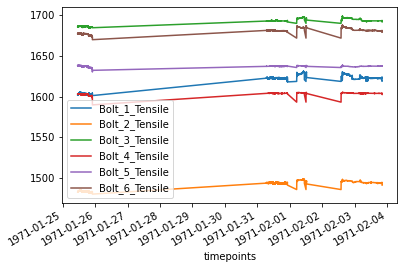

In [12]:
preds_df.plot()

In [13]:
preds_df.to_csv("../data/structured/general/predicted_tensiles.csv")